In [26]:
import lsst.daf.persistence as dafPersist
import re
import pickle
import astropy.coordinates as coord
import astropy.units as u
import Utils.DiaSourceTools as DSTools

from lsst.afw.math import afwMath


from astropy.io import ascii
import glob
import matplotlib.pyplot as plt
import numpy as np

import multiprocessing

import sncosmo

In [2]:
D/get
butler = dafPersist.Butler(DATADIR+"daycoadd_tests_3") 

In [3]:
days = []
with open(DATADIR+"/days_04.txt", "rb") as dayFile:
    for line in dayFile:
            line = line.replace('\n','')
            #text = re.split("=| ",line)
            days.append(line)

patches= []
with open(DATADIR+"/patches.txt", "rb") as patches_file:
    for line in patches_file:
            line = line.replace('\n','')
            text = re.split("=| ",line)
            patches.append(text[-1])
    



In [4]:
missing_patches = []


for patch in patches:
        if butler.datasetExists("deepCoadd_calexp", dataId={"tract":0, "patch":patch, "filter":"r"}) == False:
            missing_patches.append(patch)

In [5]:
missing_patches

['0,5',
 '0,6',
 '0,7',
 '0,8',
 '0,9',
 '0,10',
 '0,11',
 '0,12',
 '0,13',
 '0,14',
 '0,15',
 '0,16',
 '0,17',
 '0,18',
 '0,19',
 '0,20',
 '0,21',
 '0,22',
 '0,23',
 '0,24',
 '0,25',
 '1,5',
 '1,6',
 '1,7',
 '1,8',
 '1,9',
 '1,10',
 '1,11',
 '1,12',
 '1,13',
 '1,14',
 '1,15',
 '1,16',
 '1,17',
 '1,18',
 '1,19',
 '1,20',
 '1,21',
 '1,22',
 '1,23',
 '1,24',
 '1,25',
 '2,5',
 '2,6',
 '2,7',
 '2,8',
 '2,9',
 '2,10',
 '2,11',
 '2,12',
 '2,13',
 '2,14',
 '2,15',
 '2,16',
 '2,17',
 '2,18',
 '2,19',
 '2,20',
 '2,21',
 '2,22',
 '2,23',
 '2,24',
 '2,25',
 '3,5',
 '3,6',
 '3,7',
 '3,8',
 '3,9',
 '3,10',
 '3,11',
 '3,12',
 '3,13',
 '3,14',
 '3,15',
 '3,16',
 '3,17',
 '3,18',
 '3,19',
 '3,20',
 '3,21',
 '3,22',
 '3,23',
 '3,24',
 '3,25',
 '4,5',
 '4,6',
 '4,7',
 '4,8',
 '4,9',
 '4,10',
 '4,11',
 '4,12',
 '4,13',
 '4,14',
 '4,15',
 '4,16',
 '4,17',
 '4,18',
 '4,19',
 '4,20',
 '4,21',
 '4,22',
 '4,23',
 '4,24',
 '4,25',
 '5,5',
 '5,20',
 '5,25',
 '6,5',
 '6,25',
 '7,5',
 '7,25',
 '8,5',
 '8,25',
 '9

In [8]:
f = open('/renoir_data_02/jpreyes/lsst_data/sn_control/J_A+A_523_A7_table9.dat.txt','r')
data_elems = f.read()
#elems = re.findall('^(.*?D3.*?)\\|(.*?)\\|', data_elems, re.MULTILINE)
elems = re.findall('^(04D3.*?)\\|(.*?)\\|(.*?)\\|(.*?)\\|(.*?)\\|(.*?)\\|(.*?)\\|', data_elems, re.MULTILINE)
f.close()

f = open('/renoir_data_02/jpreyes/lsst_data/sn_control/J_A+A_523_A7_table10.dat.txt','r')
data = f.read()
f.close()

snls_array = []
for sn in elems:

        c = coord.SkyCoord(sn[1], unit=(u.hourangle, u.deg))

        m = re.findall('^'+str(sn[0])+'\\|(r|g|z|i)\\|(.*?)\\|(.*?)\\|(.*?)$', data, re.MULTILINE)

        snls_lc = DSTools.build_light_curve_from_snls_file_2(m, c, sn[0], sn[-1])

        if len(m)>0:
            #print sn[0], c.ra.deg, c.dec.deg

            #plt.errorbar(snls_lc['mjd'], snls_lc['flux'], yerr=snls_lc['flux_error'], fmt='.', color='blue')
            #show_multi_filter_light_curve(snls_lc, snls_colors)
            plt.show()
            snls_array.append(snls_lc)

print("total of sn:" + str(len(snls_array)))

total of sn:25


In [203]:
def get_mean(calexp):
    mi = calexp.getMaskedImage()
    bad = ~calexp.getMaskedImage().getMask().getPlaneBitMask(['DETECTED' ])
    sctrl = afwMath.StatisticsControl()
    sctrl.setAndMask(bad)
    stats = afwMath.makeStatistics(mi, afwMath.MEAN, sctrl)
    return (stats.getValue(afwMath.MEAN))


def get_mean2(calexp):
    img = calexp.getMaskedImage().getImage().getArray()
    
    marr= deepcopy(calexp.getMaskedImage().getMask().getArray())
    m = calexp.getMaskedImage().getMask().getPlaneBitMask(['DETECTED' ])

    #marr = np.ravel(marr)
    marr[marr!=m]=0
    
    t_sum = 0;
    count = 0
    for a,b in zip(img.ravel(), marr.ravel()):
        if b==32:
            t_sum +=a
            count+=1
        
    return t_sum/count

def get_threshold2(calexp):
    img = calexp.getMaskedImage().getImage().getArray()

    mi = calexp.getMaskedImage()
    marr= deepcopy(calexp.getMaskedImage().getMask().getArray())
    bad = calexp.getMaskedImage().getMask().getPlaneBitMask(['BAD', 'SAT', 'EDGE', 'NO_DATA', 'DETECTED'])
    
    marr[marr==bad]=0
    
    
    
    return np.std(marr)

def get_threshold(dayDiff):
    factor = 1

    mi = dayDiff.getMaskedImage()
    bad = dayDiff.getMaskedImage().getMask().getPlaneBitMask(['BAD', 'SAT', 'EDGE', 'NO_DATA', ])
    sctrl = afwMath.StatisticsControl()
    sctrl.setAndMask(bad)
    stats = afwMath.makeStatistics(mi, afwMath.STDEVCLIP, sctrl)
    thres = (stats.getValue(afwMath.STDEVCLIP) * factor)
    return thres


def read_lc_files(obj):
    table = ascii.read(obj)
    return table

def match_with_lc(slc):
    matches = []
    for lc in snls_array:
        #print "light curve"
        val = {"ra":lc[0]["ra"], "dec":lc[0]["dec"]}
        #print np.rad2deg(lc[0]["ra"]), np.rad2deg(lc[0]["dec"])
        

        comp = {"ra":np.mean(slc["ra"]), "dec":np.mean(slc["dec"])}
        if DSTools.source_distance(val, comp)<1:
            #print "match"
            matches.append((lc,slc))


    #print len(matches)
    return matches


def get_total_matches(f, sigma, folder_name = "light_curves_adapted"):
    lienObj = glob.glob("/datadec/cppm/jpreyes/CFHT_Production/"+folder_name+"_"+f+"_"+str(float(sigma))+"sigma/*.dat")
    #lienObj = glob.glob("/datadec/cppm/jpreyes/CFHT_Production/"+folder_name+"_"+str(float(sigma))+"sigma/*.dat")

    print len(lienObj)

    try:
        pool = multiprocessing.Pool()
        res =  pool.map(read_lc_files, lienObj)
    finally:
        pool.close()

    s_candidates = res
    print len(s_candidates)

    try:
        pool = multiprocessing.Pool()
        match_res =  pool.map(match_with_lc, s_candidates)
    finally:
        pool.close()

    res_final = []
    for r in match_res:
        res_final +=r

    count = 0
    ids = []
    for control, match in res_final:
        if control[0]["id"] not in ids:
            count+=1
            ids.append(control[0]["id"])

    print count
    
    return res_final

In [15]:
tmatches_before = get_total_matches("r", 5.5, folder_name="light_curves_adapted_reroll")


18695
18695
14


In [11]:
tmatches_before = get_total_matches("r", 5.5, folder_name="light_curves_daycoadd_control_reroll")

27395
27395
18


In [13]:
tmatches_before = get_total_matches("r", 5.5, folder_name="light_curves_control_reroll")

27395
27395
18


In [14]:
tmatches_before = get_total_matches("r", 5.5, folder_name="light_curves_control")

43869
43869
18


In [25]:
tmatches_before = get_total_matches("r", 5.5, folder_name="light_curves_daycoadd_reroll")

55502
55502
11


In [29]:
tmatches_before = get_total_matches("r", 5.5, folder_name="light_curves_daycoadd_reroll_r")

123303
123303
15


In [32]:
butler = dafPersist.Butler(DATADIR+"daycoadd_reroll")
date_catalog = butler.get("dayDiff_class_diaSrc", dataId={"filter":"r","tract":0, "patch":"15,15", 'date':"2004-05-09"})
print len(date_catalog) 

490


In [33]:
butler2 = dafPersist.Butler(DATADIR+"detect_prod")
date_catalog = butler2.get("dayDiff_class_diaSrc", dataId={"filter":"r","tract":0, "patch":"15,15", 'date':"2004-05-09"})
print len(date_catalog) 

313


In [186]:
butler = dafPersist.Butler(DATADIR+"tests_reroll")
date_catalog = butler.get("dayDiff_class_diaSrc", dataId={"filter":"r","tract":0, "patch":"15,15", 'date':"2004-05-09"})
print len(date_catalog) 
date_catalog = butler.get("dayDiff_class_diaSrc", dataId={"filter":"r","tract":0, "patch":"14,14", 'date':"2004-05-09"})
print len(date_catalog) 

189
837


In [187]:
butler = dafPersist.Butler(DATADIR+"control_reroll")
date_catalog = butler.get("dayDiff_class_diaSrc", dataId={"filter":"r","tract":0, "patch":"15,15", 'date':"2004-05-09"})
print len(date_catalog) 
date_catalog = butler.get("dayDiff_class_diaSrc", dataId={"filter":"r","tract":0, "patch":"14,14", 'date':"2004-05-09"})
print len(date_catalog) 

313
300


In [207]:
butler = dafPersist.Butler(DATADIR+"control_reroll", immediate=False)

In [208]:
vals = butler.subset("calexp",dataId={"runId":"05AL01", "filter":"r", "ccd":15})


In [209]:
print len(vals)
for s in vals:
    print s.dataId["visit"]

142
788965
788964
788962
784394
784514
780832
781475
781478
788104
788486
788484
788960
784517
787671
780835
788483
780829
788961
787674
788100
780355
787677
784261
788101
781479
788963
780353
784515
781476
784260
784257
787673
780833
780834
788485
784259
784516
781477
787676
780352
787675
784262
788099
787672
788482
780354
780830
784518
780356
788103
796723
793569
793919
797545
793168
797099
793922
792271
796219
796724
793920
795841
796216
792269
792181
797101
792272
797548
796220
792755
796722
795844
792753
792273
793572
795840
793167
797546
797103
797547
792756
792179
793570
792180
796221
796223
793571
796222
793169
796725
792757
797102
793165
795842
795843
792758
792754
797549
793918
793166
793921
792270
796218
796721
793568
796217
792182
797100
805371
803022
800717
800718
802229
805373
802230
805369
806145
801148
800719
801145
800721
806143
805370
806141
803023
805367
801144
805368
806144
803025
802227
803024
802231
800720
801146
805374
806142
805375
801147
802228
803021
805372


In [210]:
dict_vals = []
for s in vals:
    dId = {"tract":0, "filter":"r", "patch":"14,14", "visit":s.dataId["visit"]}
    if butler.datasetExists("deepCoadd_tempExp", dataId=dId):
        exp = butler.get("deepCoadd_tempExp", dataId=dId)
        dict_vals.append((get_mean2(exp)/get_threshold2(exp), s.dataId["visit"], exp)  )

In [211]:
dict_vals

[(9.9226887227763729,
  805371,
  <lsst.afw.image.exposure.exposure.ExposureF at 0x7fa35619f688>),
 (17.714521627189121,
  803022,
  <lsst.afw.image.exposure.exposure.ExposureF at 0x7fa35619f420>),
 (11.485838348611138,
  802229,
  <lsst.afw.image.exposure.exposure.ExposureF at 0x7fa35619f308>),
 (10.895866285457709,
  802230,
  <lsst.afw.image.exposure.exposure.ExposureF at 0x7fa33aabb9d0>),
 (12.108208974396998,
  805369,
  <lsst.afw.image.exposure.exposure.ExposureF at 0x7fa33aabb960>),
 (12.646932195274085,
  805370,
  <lsst.afw.image.exposure.exposure.ExposureF at 0x7fa33aabbed8>),
 (20.665841044768147,
  803023,
  <lsst.afw.image.exposure.exposure.ExposureF at 0x7fa33aabbbc8>),
 (8.4818383834202269,
  805368,
  <lsst.afw.image.exposure.exposure.ExposureF at 0x7fa33aabb030>),
 (19.228847973131796,
  803025,
  <lsst.afw.image.exposure.exposure.ExposureF at 0x7fa35619f880>),
 (11.908857374028644,
  802227,
  <lsst.afw.image.exposure.exposure.ExposureF at 0x7fa34e9c04c8>),
 (16.58222

In [212]:
import operator

sorted_x = sorted(dict_vals, key=operator.itemgetter(0))

In [213]:
sorted_x[-15:]

[(8.4818383834202269,
  805368,
  <lsst.afw.image.exposure.exposure.ExposureF at 0x7fa33aabb030>),
 (9.2493989497461477,
  802231,
  <lsst.afw.image.exposure.exposure.ExposureF at 0x7fa34e9c0688>),
 (9.9226887227763729,
  805371,
  <lsst.afw.image.exposure.exposure.ExposureF at 0x7fa35619f688>),
 (10.895866285457709,
  802230,
  <lsst.afw.image.exposure.exposure.ExposureF at 0x7fa33aabb9d0>),
 (11.074020893613614,
  805372,
  <lsst.afw.image.exposure.exposure.ExposureF at 0x7fa34e9c0880>),
 (11.485838348611138,
  802229,
  <lsst.afw.image.exposure.exposure.ExposureF at 0x7fa35619f308>),
 (11.908857374028644,
  802227,
  <lsst.afw.image.exposure.exposure.ExposureF at 0x7fa34e9c04c8>),
 (12.076525049659798,
  802228,
  <lsst.afw.image.exposure.exposure.ExposureF at 0x7fa34e9c0dc0>),
 (12.108208974396998,
  805369,
  <lsst.afw.image.exposure.exposure.ExposureF at 0x7fa33aabb960>),
 (12.646932195274085,
  805370,
  <lsst.afw.image.exposure.exposure.ExposureF at 0x7fa33aabbed8>),
 (16.58222

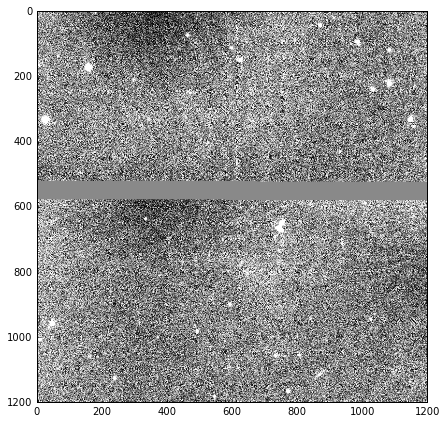

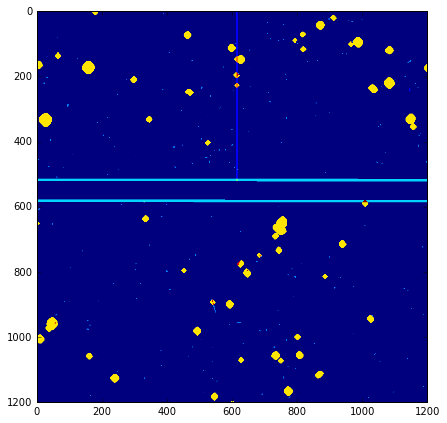

In [151]:
plt.figure(figsize=(7,7))
img = sorted_x[11][-1].getMaskedImage().getImage().getArray()
#img = np.flipud(img)
plt.imshow(img, cmap="gray", vmin =-70, vmax=60)
plt.show()

plt.figure(figsize=(7,7))
mask_bit = sorted_x[11][-1].getMaskedImage().getMask().getArray()
plt.imshow(mask_bit)
plt.show()

In [132]:
from copy import deepcopy
marr= deepcopy(sorted_x[11][-1].getMaskedImage().getMask().getArray())
m = sorted_x[11][-1].getMaskedImage().getMask().getPlaneBitMask(['DETECTED' ])

#marr = np.ravel(marr)
marr[marr!=m]=0
#marr.reshape(1200,1200)

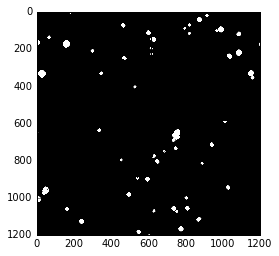

In [134]:
plt.imshow(marr, cmap="gray")
plt.show()

In [152]:
t_sum = 0;
count = 0
for a,b in zip(img.ravel(), marr.ravel()):
    if b==32:
        t_sum +=a
        count+=1
        
print t_sum/count

96.1207912855


In [138]:
get_mean(sorted_x[11][-1])

1.0606944946430148

In [150]:
get_mean_2(sorted_x[11][-1])

96.120791285509569